In [192]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from pytorch3d.transforms import quaternion_multiply, quaternion_raw_multiply, quaternion_invert, \
    matrix_to_quaternion, axis_angle_to_quaternion
from tqdm import tqdm

In [193]:
import pickle
import sys
import time 

def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

suite = "testset"
dataset="11"
ifile = f"../data/{suite}/imu/imuRaw{dataset}.p"
vfile = f"../data/{suite}/vicon/viconRot{dataset}.p"

ts = tic()
imud = read_data(ifile)
if suite == "trainset":
  vicd = read_data(vfile)
toc(ts,"Data import")

Data import took: 0.0013751983642578125 sec.



In [194]:
def plot_quaternions(Q, T):
    # Plot each quaternion component against timestamps
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))

    for i in range(4):
        axs[i].plot(T.squeeze(), Q[:, i])
        axs[i].set_title(f'Quaternion Component {i+1} vs Time')
        axs[i].set_ylim([-1.1,1.1])
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(f'Component {i+1}')

    plt.tight_layout()
    plt.show()


def plot_quaternions_mul(Packs):
    # Plot each quaternion component against timestamps
    '''
    Pack [(Q, T), [], []...]
    '''
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))

    handles, labels = [], []
    for i in range(4):
        for pack in Packs:
            line, = axs[i].plot(pack[1].squeeze(), pack[0][:, i], 
                                label=pack[2],
                                linestyle=pack[3],
                                c=pack[4])
            if i == 0:
                handles.append(line)
                labels.append(pack[2])
        axs[i].set_title(f'Quaternion Component {i+1} vs Time')
        axs[i].set_ylim([-1.1,1.1])
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(f'Component {i+1}')

    fig.subplots_adjust(bottom=0.25, hspace=0.4)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

    plt.tight_layout()
    plt.show()


def plot_euler_mul(Packs):
    # Plot each quaternion component against timestamps
    '''
    Pack [(Q, T), [], []...]
    '''
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    handles, labels = [], []
    for i in range(3):
        for pack in Packs:
            line, = axs[i].plot(pack[1].squeeze(), pack[0][:, i], 
                        label=pack[2],
                        linestyle=pack[3],
                        c=pack[4])
            if i == 0:
                handles.append(line)
                labels.append(pack[2])
        axs[i].set_title(f'Euler Angle {i+1} vs Time')
        axs[i].set_ylim([-math.pi,math.pi])
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(f'Angle {i+1}')

    fig.subplots_adjust(bottom=0.25, hspace=0.4)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

    plt.tight_layout()
    plt.show()

if suite == "trainset":
    Q_ground_truth = matrix_to_quaternion(torch.from_numpy(vicd['rots'].transpose([2,0,1])))
    Q_ground_truth[Q_ground_truth[:, 0] < 0] *= -1
# plot_quaternions_mul([(Q_ground_truth, vicd['ts'], "vic ground truth", "-")])

In [195]:
A_raw = imud['vals'][[0,1,2],:].T.astype(np.float64)
W_raw = imud['vals'][[4,5,3],:].T.astype(np.float64)
T_raw = imud["ts"].squeeze()

A_raw, W_raw

(array([[510., 501., 606.],
        [511., 501., 606.],
        [511., 501., 606.],
        ...,
        [511., 501., 605.],
        [511., 501., 606.],
        [511., 501., 606.]]),
 array([[374., 376., 370.],
        [374., 376., 371.],
        [374., 376., 370.],
        ...,
        [374., 375., 370.],
        [373., 375., 370.],
        [372., 375., 369.]]))

In [196]:
np.mean(A_raw[0:100,:],axis=0)

array([510.78, 501.  , 605.95])

In [197]:
def accelerometor_unit(raw):
    scale_factor = 3300 / 1023 / 300
    bias = np.mean(raw[0:50,],axis=0)
    re = (raw-bias)*scale_factor
    re[:,2] += 1
    return re

def pitch_roll_unit(raw):
    scale_factor = 3300 / 1023 / 3.33 * (math.pi/180)
    bias = np.mean(raw[0:50],axis=0)
    return (raw-bias)*scale_factor

A_unit = accelerometor_unit(A_raw) * np.array([[-1,-1,1]])
W_unit = pitch_roll_unit(W_raw)

A_unit, W_unit

(array([[ 0.00774194, -0.        ,  1.00043011],
        [-0.00301075, -0.        ,  1.00043011],
        [-0.00301075, -0.        ,  1.00043011],
        ...,
        [-0.00301075, -0.        ,  0.98967742],
        [-0.00301075, -0.        ,  1.00043011],
        [-0.00301075, -0.        ,  1.00043011]]),
 array([[ 0.00608659,  0.01014431,  0.0054103 ],
        [ 0.00608659,  0.01014431,  0.02231749],
        [ 0.00608659,  0.01014431,  0.0054103 ],
        ...,
        [ 0.00608659, -0.00676288,  0.0054103 ],
        [-0.0108206 , -0.00676288,  0.0054103 ],
        [-0.02772779, -0.00676288, -0.01149689]]))

In [198]:
len = T_raw.shape[0]
T_torch = torch.from_numpy(T_raw)
dT = T_torch[1:] - T_torch[:-1]
A_torch = torch.cat((torch.zeros(len, 1), torch.from_numpy(A_unit)), dim=1)
W_torch = torch.from_numpy(W_unit)

In [199]:
def quaternion_exp(q):
    """
    Exponential of a quaternion.
    """
    q_s = q[..., 0:1]
    q_v = q[..., 1:]
    norm_v = torch.norm(q_v, dim=-1, keepdim=True) + 1e-4
    real_part = torch.exp(q_s) * torch.cos(norm_v)
    imag_part = torch.exp(q_s) * (q_v / norm_v) * torch.sin(norm_v)
    return torch.cat([real_part, imag_part], dim=-1)

def quaternion_log(q):
    """
    Logarithm of a quaternion.
    """
    q_s = q[..., 0:1]
    q_v = q[..., 1:]
    norm_v = torch.norm(q_v, p=2, dim=-1, keepdim=True) + 1e-12
    norm_q = torch.norm(q, p=2, dim=-1, keepdim=True) + 1e-12
    
    real_part = torch.log(norm_q)
    imag_part = torch.acos(q_s / norm_q) * (q_v / norm_v)
    return torch.cat([real_part, imag_part], dim=-1)

def f(q, tau, w):
    omega_qt = torch.cat([torch.zeros_like(w[:, :1]), tau.unsqueeze(-1) * w/2], dim=1)
    exp_omega = quaternion_exp(omega_qt)
    return quaternion_raw_multiply(q, exp_omega)

def h(q):
    g = torch.tensor([0, 0, 0, 1], dtype=q.dtype, device=q.device)
    g = g.expand_as(q)
    q_inv = quaternion_invert(q)
    return quaternion_raw_multiply(quaternion_raw_multiply(q_inv, g), q)

In [200]:
g = torch.tensor([0, 0, 1.0],dtype=torch.float64)
A_norm = torch.from_numpy(A_unit) / torch.norm(torch.from_numpy(A_unit), dim=1, keepdim=True)
cross_prod = torch.cross(A_norm,g.expand_as(A_norm), dim=1)
sin_angle = torch.norm(cross_prod, dim=1)
cos_angle = torch.sum(A_norm * g.expand_as(A_norm), dim=1)
angle = torch.atan2(sin_angle, cos_angle)
axis = cross_prod / sin_angle.unsqueeze(1)
axis_angle = axis * angle.unsqueeze(1)
Q_from_g = axis_angle_to_quaternion(axis_angle)

In [201]:
Q_from_w = torch.zeros([len, 4])
Q_from_w[0,0] = 1
for i in range(1, len):
    q = f(Q_from_w[[i-1],:], dT[i-1], W_torch[[i-1],:])
    Q_from_w[i,:] = torch.nn.functional.normalize(q)

In [202]:
# plot_quaternions_mul([
#     (Q_ground_truth, vicd['ts'], "ground_truch", '--', 'red'),
#     (Q_from_w, T_raw, "motion model", ":", 'orange'),
#     (Q_from_g, T_raw, "observation model", ":", 'green'),
# ])

In [203]:
torch.norm(A_torch - h(Q_from_g), p="fro")

tensor(6.3846, dtype=torch.float64)

In [204]:
f_val =  f(Q_from_w[:-1], dT, W_torch[:-1])
torch.norm(
    quaternion_log(quaternion_raw_multiply(quaternion_invert(Q_from_w[1:]),f_val))
, p="fro")

tensor(0.0001, dtype=torch.float64)

In [205]:
def loss_func(Q, W, A, dT):
    f_values = f(Q[:-1], dT, W[:-1])
    term1 = quaternion_raw_multiply(quaternion_invert(Q[1:]), f_values)
    term1 = 2*quaternion_log(term1)
    term1_loss = torch.norm(term1, p = "fro") ** 2

    h_values = h(Q[:-1])
    term2 = A[:-1] - h_values
    term2_loss = torch.norm(term2, p="fro")**2

    total_loss = torch.sum(term1_loss + term2_loss/2)
    return total_loss


# Q = Q_from_g.detach().clone().requires_grad_(True)
Q = Q_from_w.detach().clone().requires_grad_(True)
with torch.no_grad():
    Q.copy_(torch.nn.functional.normalize(Q, p=2, dim=1))
loss_func(Q, W_torch, A_torch, dT)

tensor(26.9790, dtype=torch.float64, grad_fn=<SumBackward0>)

In [206]:
best_Q = Q.clone()
best_loss = torch.inf

optimizer = torch.optim.SGD([Q], lr=1e-3)

num_epochs = 6000
patience = 10
epochs_since_improvement = 0
bar = tqdm(range(num_epochs))
for epoch in bar:
    with torch.no_grad():  # Ensure no gradient computation during this operation
        Q.copy_(torch.nn.functional.normalize(Q, p=2, dim=1))
    optimizer.zero_grad()
    loss = loss_func(Q, W_torch, A_torch, dT)
    loss.backward()
    optimizer.step()

    bar.set_postfix_str(f"Epoch {epoch}, Loss: {loss.item()}")
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_Q = Q.clone()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
    if epochs_since_improvement > patience:
        print(f"No improvement in {patience} epochs, stopping training.")
        break

 31%|███       | 1856/6000 [00:07<00:16, 252.73it/s, Epoch 1856, Loss: 21.151734526928504]

No improvement in 10 epochs, stopping training.


In [207]:
dataset

'11'

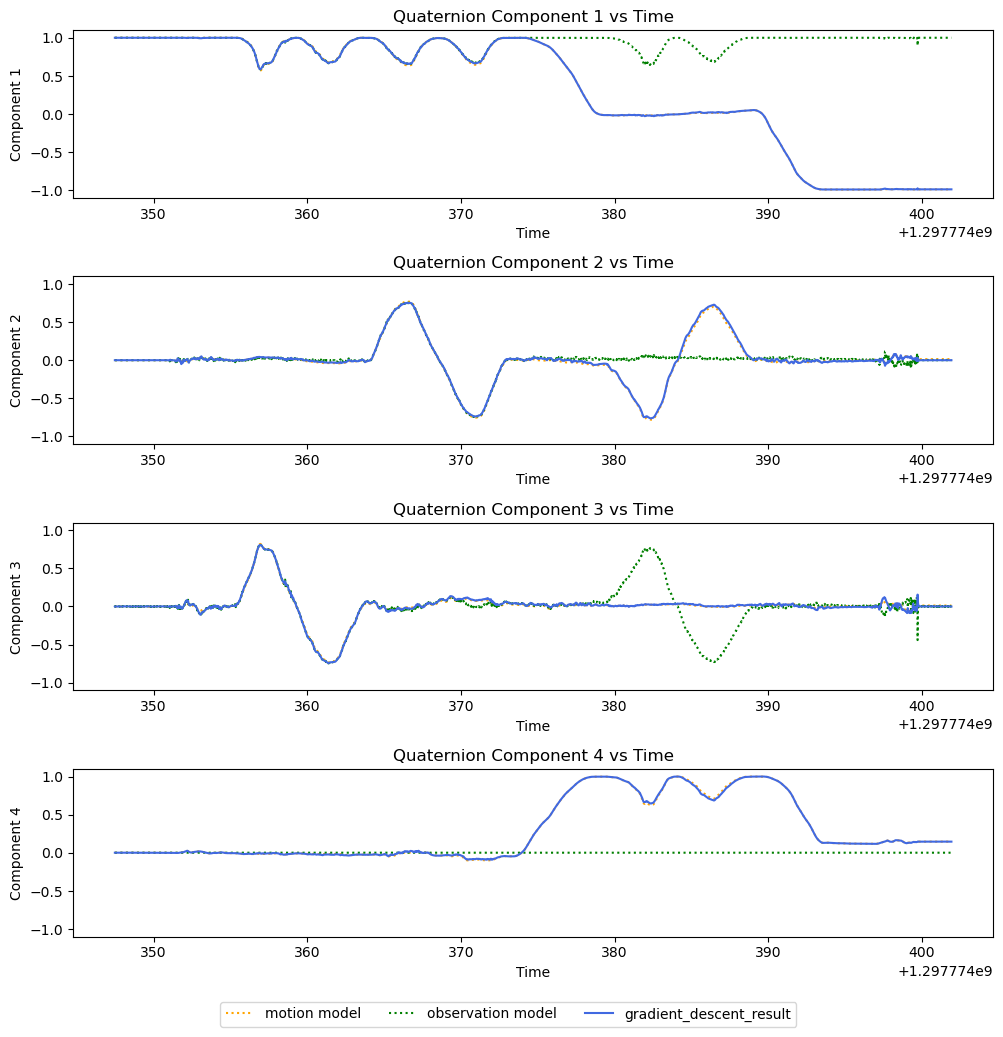

In [208]:
plot_quaternions_mul([
    # (Q_ground_truth, vicd['ts'], "ground_truch", '--', 'red'),
    (Q_from_w, T_raw, "motion model", ":", 'orange'),
    (Q_from_g, T_raw, "observation model", ":", 'green'),
    (best_Q.detach().numpy(), T_raw, "gradient_descent_result", "-", "royalblue"),
])

In [209]:
# torch.save(Q, f'{dataset}_best_gd_Q.pt')

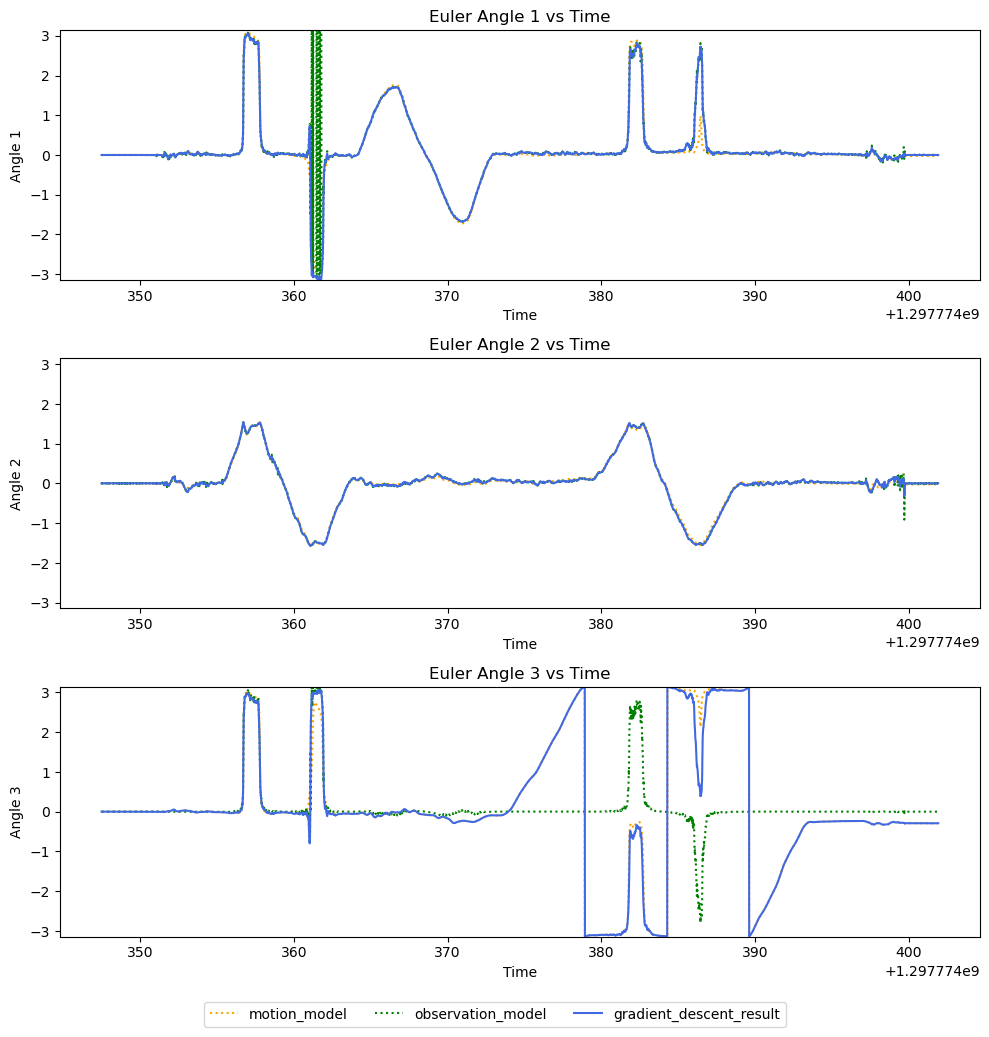

In [210]:
import transformations as tf

def quaternion_to_euler_torch(quaternions):
    """
    Convert a batch of quaternions to Euler angles using transformations library.
    :param quaternions: A torch tensor of shape (N, 4) representing quaternions.
    :return: A NumPy array of shape (N, 3) representing Euler angles.
    """
    quaternions = quaternions.detach().numpy()  # Convert to NumPy array
    eulers = np.array([tf.euler_from_quaternion(q) for q in quaternions])
    return eulers

plot_euler_mul([
    # (quaternion_to_euler_torch(Q_ground_truth), vicd['ts'], "ground_truth", "--", 'red'),
    (quaternion_to_euler_torch(Q_from_w), T_raw, "motion_model", ":", 'orange'),
    (quaternion_to_euler_torch(Q_from_g), T_raw, "observation_model", ":", "green"),
    (quaternion_to_euler_torch(best_Q), T_raw, "gradient_descent_result", "-", "royalblue"),
])